In [1]:
import numpy as np
import cv2
import cv2.ximgproc as cvx
import matplotlib.pyplot as plt
from domain_transform import DomainTransform
from skimage.io import imread

dt = DomainTransform()

In [2]:
lmbd = 0.99

In [3]:
def derivative(zi, confidence, target, reference, lmbd):
    return lmbd*(zi - reference) + confidence*(zi - target)    

In [4]:
def cost(zi, confidence, target, reference, lmdb):
    cost_matrix1 = np.power(zi - reference, 2)
    cost_matrix2 = confidence*np.power(zi - target, 2)
    sum1 = (lmbd/2)*np.sum(np.sum(cost_matrix1, axis=0), axis=0)
    sum2 = (lmbd/2)*np.sum(np.sum(cost_matrix2, axis=0), axis=0)
    return sum1 + sum2

In [5]:
reference = imread('depth_superres/reference.png')
reference = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)/ 255.0
target = imread('depth_superres/target.png')
confidence = imread('depth_superres/confidence.png')
gt = imread('depth_superres/ground_truth.png')

Convert to domain [0,1] as bilateral solver example

In [6]:
t = target.astype(np.double)/(pow(2,16)-1)
c = confidence.astype(np.double)/(pow(2,16)-1)

In [7]:
reference = reference.astype(np.float32)
t = t.astype(np.float32)
c = c.astype(np.float32)

Joint filtering the target map using the reference as parameter(The same way described in the DT paper).
This is equivalent to equation (10) in DTSolver

In [8]:
#filtered_target = dt.normalized_convolution(t, 200, 0.55, 3, reference)
filtered_target = cvx.dtFilter(reference, t, 800, 0.25, mode=cvx.DTF_NC, numIters=3)

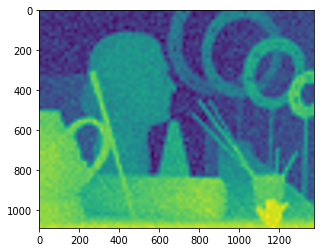

In [9]:
plt.imshow(target)

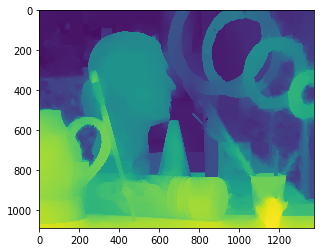

In [10]:
plt.imshow(filtered_target)

### Sample of one iteration 

In [11]:
zi = t

In [12]:
cost1 = cost(zi, c, t, filtered_target, lmbd)
cost1

1068.8739477539064

Derivative

In [13]:
der = derivative(zi, c, t, filtered_target,lmbd)

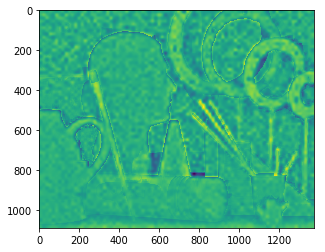

In [14]:
plt.imshow(der)

First gradient descent iteration

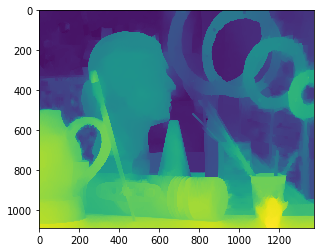

In [15]:
zi = zi - 0.99*der
plt.imshow(zi)

Second iteration

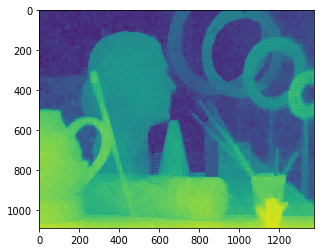

In [24]:
der = derivative(zi, c, t, filtered_target,lmbd)
zi = zi - 0.99*der
plt.imshow(zi)

It begins to display the confidence as the second term of the error in F is not zero anymore

In [25]:
cv2.imwrite("zi.png", zi*255)

True

Using multiple iterations

In [297]:
filtered_target = cvx.dtFilter(reference, t, 400, 0.25, mode=cvx.DTF_NC, numIters=3)

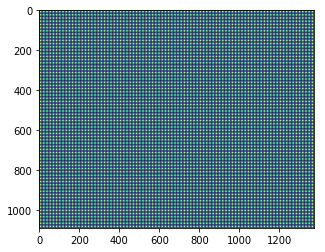

In [298]:
plt.imshow(confidence)

In [509]:
def solve(zi=None,c=None,t=None,zn=None, lmbd=None):
    r = zi
    for i in range(0, 300):
        der = derivative(r, c, t, zn,lmbd)
        r = r - 0.99*der
    return r

In [512]:
zi = t
result = solve(zi, c, t, filtered_target, lmbd)

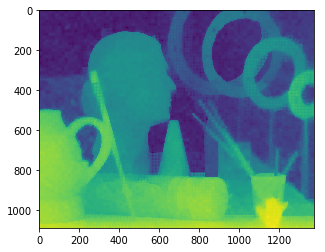

In [513]:
plt.imshow(result)

In [491]:
lmbd

0.99

Calculate root mean square error

In [492]:
def rms(gt, test):
    total = gt.shape[0] * gt.shape[1]
    sq_diff = np.power((gt - test), 2)
    summed = np.sum(np.sum(sq_diff))
    return np.sqrt(summed/total)

In [527]:
rms(gt, filtered_target*255)

9.25948469485724

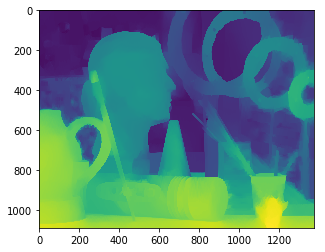

In [494]:
plt.imshow(filtered_target)